In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
%matplotlib inline

In [19]:
tf.__version__

'2.10.0'

# Import Training and Validation data

In [2]:
def randomly_crop_or_resize(x,y):
    """ Randomly crops or resizes the images """
 
    def rand_crop(x, y):                                                  
        """ Randomly crop images after enlarging them """
        x = tf.image.resize(x, resize_to_before_crop, method='bilinear')  
        y = tf.cast(                                                      
                tf.image.resize(
                    tf.transpose(y,[1,2,0]),                              
                    resize_to_before_crop, method='nearest'
                ),
                'float32'
            )          
 
        offset_h = tf.random.uniform(
            [], 0, x.shape[0]-input_size[0], dtype='int32'
        )                                                                 
        offset_w = tf.random.uniform(
            [], 0, x.shape[1]-input_size[1], dtype='int32'
        )                                                                 
        x = tf.image.crop_to_bounding_box(
            image=x, 
            offset_height=offset_h, offset_width=offset_w,
            target_height=input_size[0], target_width=input_size[1]       
        )
        y = tf.image.crop_to_bounding_box(
            image=y, 
            offset_height=offset_h, offset_width=offset_w,
            target_height=input_size[0], target_width=input_size[1]       
        )
 
        return x, y
 
    def resize(x, y):
        """ Resize images to a desired size """
        x = tf.image.resize(x, input_size, method='bilinear')             
        y = tf.cast(
                tf.image.resize(
                    tf.transpose(y,[1,2,0]),                                        
                    input_size, method='nearest'                          
                ),
                'float32'
            )          
 
        return x, y
 
    rand = tf.random.uniform([], 0.0,1.0)                                 
 
    if augmentation and (input_size[0] < resize_to_before_crop[0] or input_size[1] < resize_to_before_crop[1]):
        x, y = tf.cond(
                rand < 0.5,                                               
                lambda: rand_crop(x, y),
                 lambda: resize(x, y)
                )
    else:
        x, y = resize(x, y)                                           
 
        return x, y

In [10]:
np.__version__

'1.23.4'

In [7]:
IMG_SIZE = 128
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

def map_func(feature_path):
  feature = np.load(feature_path)
  # feature = 
  return feature

def process_img(file_path):
  # print(file_path)
  img = tf.io.read_file(file_path)
  img = tf.io.decode_png(img, channels=3)
  # img = tf.reshape(img, [640,400])
  return img

def opencv_resize(img):
  size = (IMG_SIZE,IMG_SIZE)
  # print(type(img))
  img = img.numpy()
  res_img = cv2.resize(img, size)

  return res_img

def import_images(path):
    size = (IMG_SIZE, IMG_SIZE)
    image_ds = tf.data.Dataset.list_files(path, shuffle=False)
    image_ds = image_ds.map(lambda x: process_img(x))
    image_ds = image_ds.map(lambda x: (tf.image.resize(x, size)))
    
    return image_ds

def import_masks(path):
    size = (IMG_SIZE, IMG_SIZE)
    mask_ds = tf.data.Dataset.list_files(path, shuffle=False)
    mask_ds = mask_ds.map(lambda item: tf.numpy_function(
              map_func, [item], tf.uint8),
              num_parallel_calls=tf.data.AUTOTUNE)
    mask_ds = mask_ds.map(lambda item: tf.py_function(
        opencv_resize, [item], tf.uint8),
        num_parallel_calls=tf.data.AUTOTUNE)
    
    return mask_ds

augment = tf.keras.Sequential([
  # layers.Rando
  layers.RandomContrast((0.8, 0.9))
  # layers.Rescaling(1./255)
])


def create_data(image_ds, mask_ds):
    
    train_ds = tf.data.Dataset.zip((image_ds, mask_ds))
    train_ds = train_ds.map(lambda x, y: 
                            (
                             tf.cast(x, 'uint8')/255,
                             tf.expand_dims(y, axis=-1)
                            )
                           )
    # train_ds = train_ds.map(lambda x, y: (augment(x), augment(y)))
    # train_ds = train_ds.map(tf.image.resize_with_crop_or_pad(x, IMG_SIZE+6, IMG_SIZE+6
    
    
    return train_ds

# def augment():
    
#     return 

def create_batch(train_ds):
    BATCH_SIZE = 1
    BUFFER_SIZE = 1000
    STEPS_PER_EPOCH = 64

    train_batches = (
        train_ds
        # .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        # .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    return train_batches

In [9]:
for i in train_ds.take(1):
    print(i)

(<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01568628, 0.01568628, 0.01568628],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.05490196, 0.05490196, 0.05490196],
        [0.05098039, 0.05098039, 0.05098039],
        [0.03529412, 0.03529412, 0.03529412]],

       [[0.01568628, 0.01568628, 0.01568628],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.09803922, 0.09803922, 0.09803922],
        [0.08627451, 0.08627451, 0.08627451],
        [0.07450981, 0.07450981, 0.07450981]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.10588235, 0.10588235, 0.10588235],
        [0.09411765, 0.09411765, 0.09411765],
        [0.07450981, 0.07450981, 0.07450981]],

       ...,

       [[0.01568628, 0.01568628, 0.01568628],
        [0.0

In [8]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

train_images = import_images('Semantic_Segmentation_Dataset/train/images/*')
train_masks = import_masks('Semantic_Segmentation_Dataset/train/labels/*')
train_ds = create_data(train_images, train_masks)
# train_
train_batches = create_batch(train_ds)

valid_images = import_images('Semantic_Segmentation_Dataset/validation/images/*')
valid_masks = import_masks('Semantic_Segmentation_Dataset/validation/labels/*')
valid_ds = create_data(valid_images, valid_masks)
valid_batches = create_batch(valid_ds)

# Trying UNET

In [181]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [182]:
unet_model = build_unet_model()

In [183]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [185]:
NUM_EPOCHS = 20
# TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = 128
# VAL_SUBSPLITS = 5
# TEST_LENTH = info.splits["test"].num_examples
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              # validation_steps=VALIDATION_STEPS,
                              # validation_data=test_batches
                              )

Epoch 1/20
128/128 [==============================] - 32s 230ms/step - loss: 9.0509 - accuracy: 0.6459
Epoch 2/20
128/128 [==============================] - 30s 233ms/step - loss: 0.4679 - accuracy: 0.8373
Epoch 3/20
128/128 [==============================] - 29s 230ms/step - loss: 0.4778 - accuracy: 0.8328
Epoch 4/20
128/128 [==============================] - 30s 235ms/step - loss: 0.5089 - accuracy: 0.8283
Epoch 5/20
128/128 [==============================] - 31s 239ms/step - loss: 0.6013 - accuracy: 0.8091
Epoch 6/20
128/128 [==============================] - 31s 239ms/step - loss: 1.0517 - accuracy: 0.7630
Epoch 7/20
128/128 [==============================] - 30s 232ms/step - loss: 1.6091 - accuracy: 0.7512
Epoch 8/20
128/128 [==============================] - 30s 233ms/step - loss: 2.7035 - accuracy: 0.7709
Epoch 9/20
128/128 [==============================] - 30s 232ms/step - loss: 2.9367 - accuracy: 0.7438
Epoch 10/20
128/128 [==============================] - 30s 232ms/step - l

# Model Creation

In [189]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_SIZE, IMG_SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [190]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [193]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

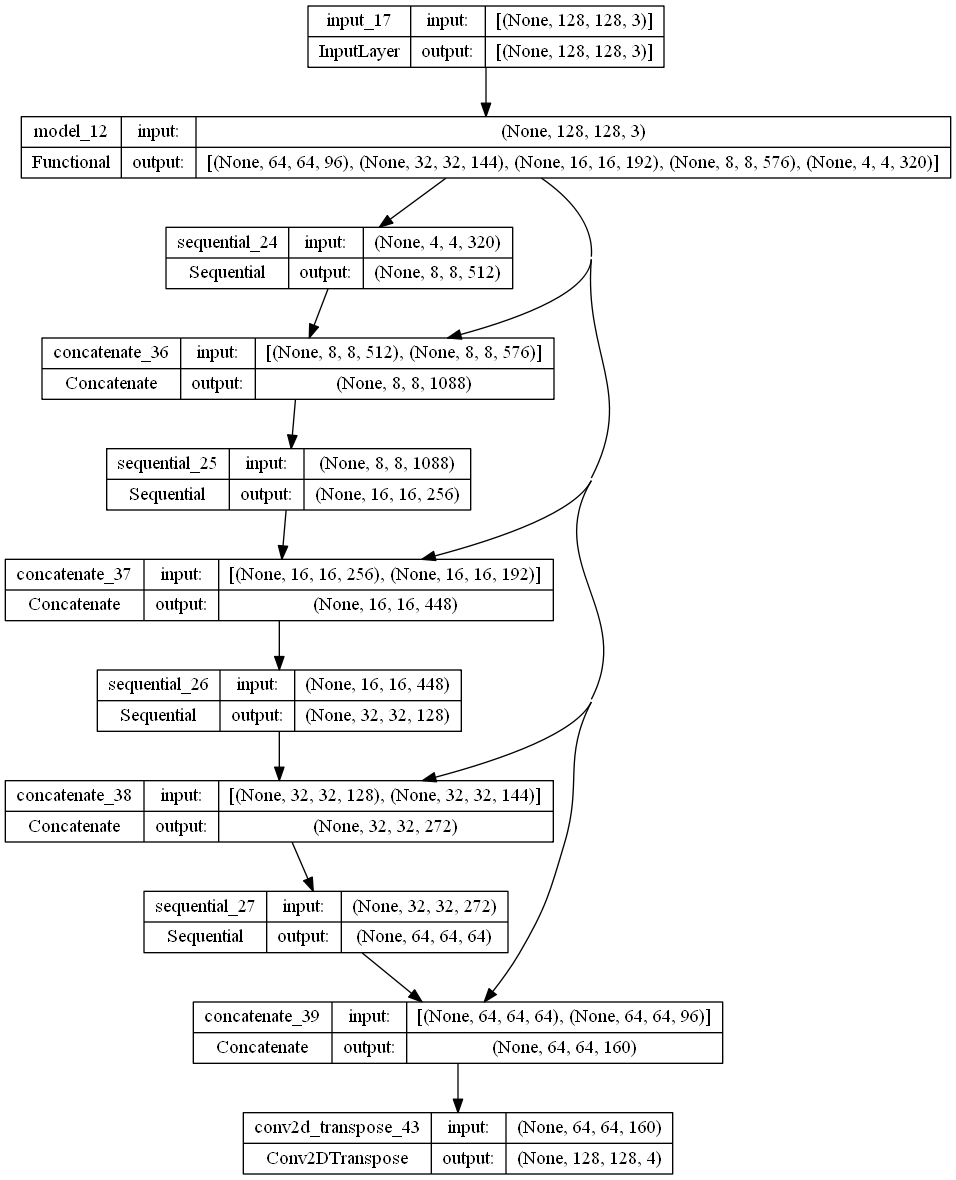

In [194]:
tf.keras.utils.plot_model(model, show_shapes=True)

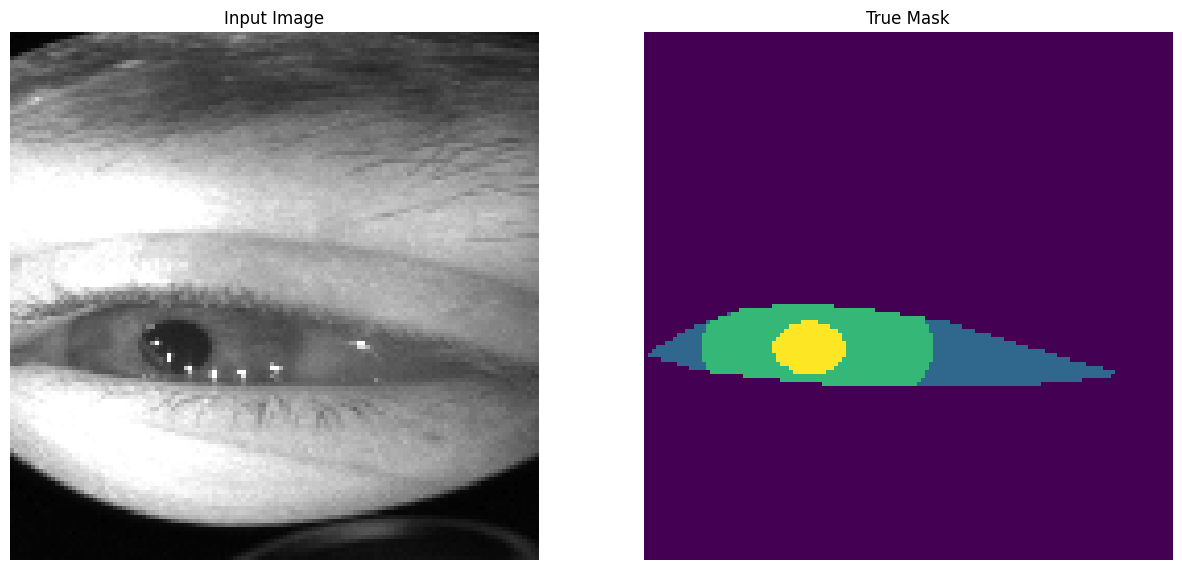

In [195]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    # print(display_list[i].shape)
    if display_list[i].shape[-1] == 1:
      display_list[i] = np.squeeze(display_list[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for images, masks in train_ds.take(1):
  sample_image, sample_mask = images, masks
  display([sample_image, sample_mask])

1/1 [==============================] - ETA: 0s

C:\Users\Ash\anaconda3\envs\pydml\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 135ms/step


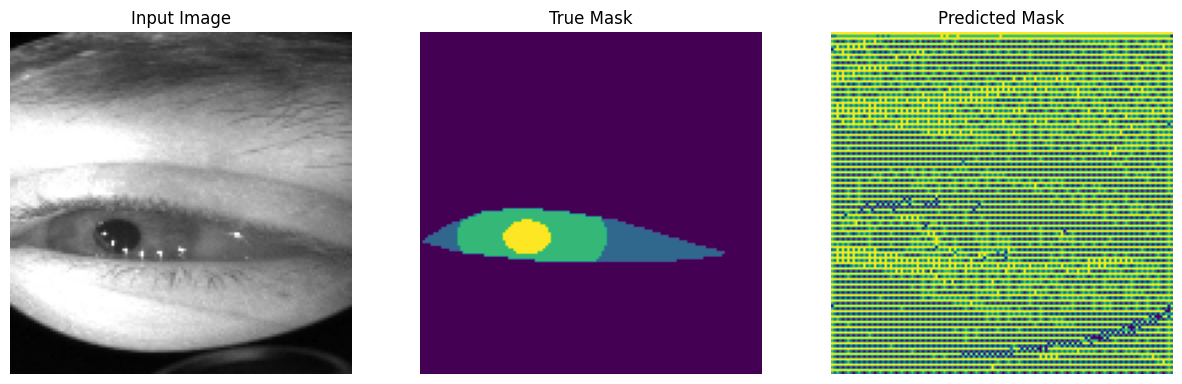

In [196]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  # pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    # display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [197]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output()
    show_predictions()
    # print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
# BATCH_SIZE = 1
# BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = 64

# train_batches = (
#     train_ds
#     # .cache()
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE)
#     .repeat()
#     # .map(Augment())
#     .prefetch(buffer_size=tf.data.AUTOTUNE))

1/1 [==============================] - 0s 117ms/step


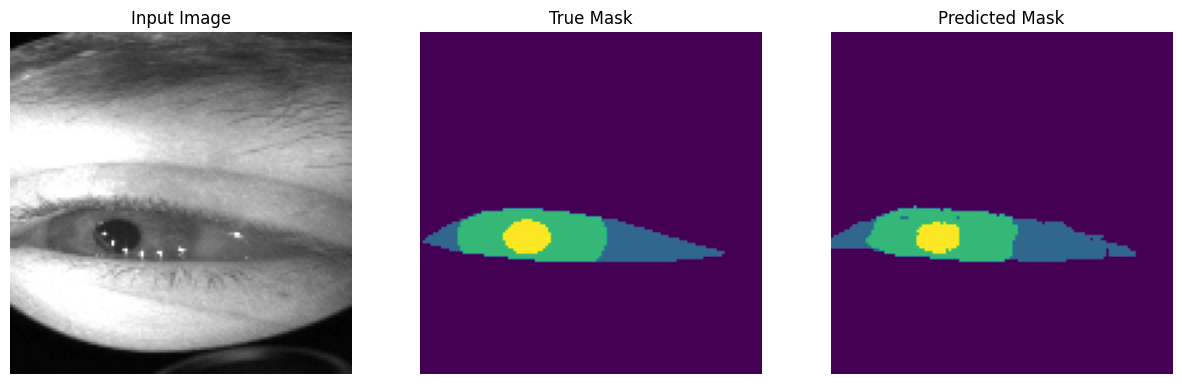

128/128 [==============================] - 34s 264ms/step - loss: 0.0410 - accuracy: 0.9840 - val_loss: 0.0638 - val_accuracy: 0.9752


In [198]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1 
# //info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_batches,
                          callbacks=[DisplayCallback()]
                         )

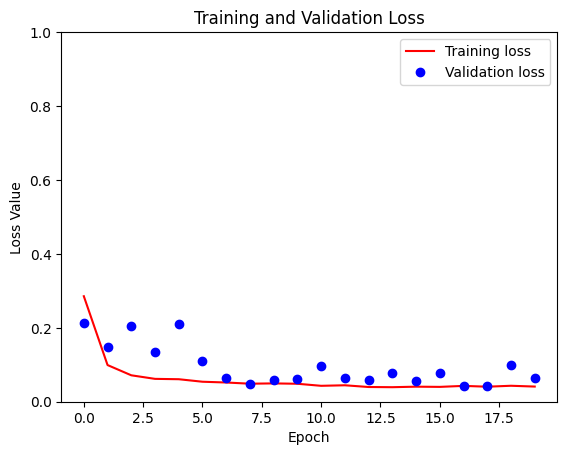

In [199]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


# Preprocess Tobii Pro Data

In [78]:
# os.mkdir('infer_split')

In [79]:
# base = 'Semantic_Segmentation_Dataset/infer_unsplit/'
# all_images = [os.path.join(base, i) for i in os.listdir('Semantic_Segmentation_Dataset/infer_unsplit/')]

# for i,j in enumerate(all_images):
#     # print(j)
#     full_frame = cv2.imread(j,0)
#     # print(full_frame)
#     for k in range(4):
#         plt.figure()
#         split = full_frame[(k)*240:(k+1)*240, :240]
#         plt.imsave(f'Semantic_Segmentation_Dataset/infer_split/{i*4+k}.png', split, cmap='gray')

In [200]:

def import_images(path):
    size = (IMG_SIZE, IMG_SIZE)
    image_ds = tf.data.Dataset.list_files(path, shuffle=False)
    image_ds = image_ds.map(lambda x: process_img(x))
    image_ds = image_ds.map(lambda x: (tf.image.resize(x, size)))
    
    return image_ds

def create_infer_data(train_ds):
    
    # train_ds = tf.data.Dataset.zip((image_ds, mask_ds))
    train_ds = train_ds.map(lambda x : (tf.cast(x, 'uint8')/255))
    
    return train_ds

def show_infer_predictions(dataset=None, num=1):
  if dataset:
    print('dataset read')
    for image in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], create_mask(pred_mask)])
  else:
    print('dataset not read')
    # display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
def create_infer_batch(train_ds):
    BATCH_SIZE = 1
    BUFFER_SIZE = 1000
    STEPS_PER_EPOCH = 64

    train_batches = (
        train_ds
        # .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        # .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    return train_batches
    

infer_images = import_images('Semantic_Segmentation_Dataset/infer_split/*')
infer_data = create_infer_data(infer_images)
infer_batch = create_infer_batch(infer_data)

show_infer_predictions(dataset=infer_batch, num=10)

dataset read
1/1 [==============================] - 0s 154ms/step


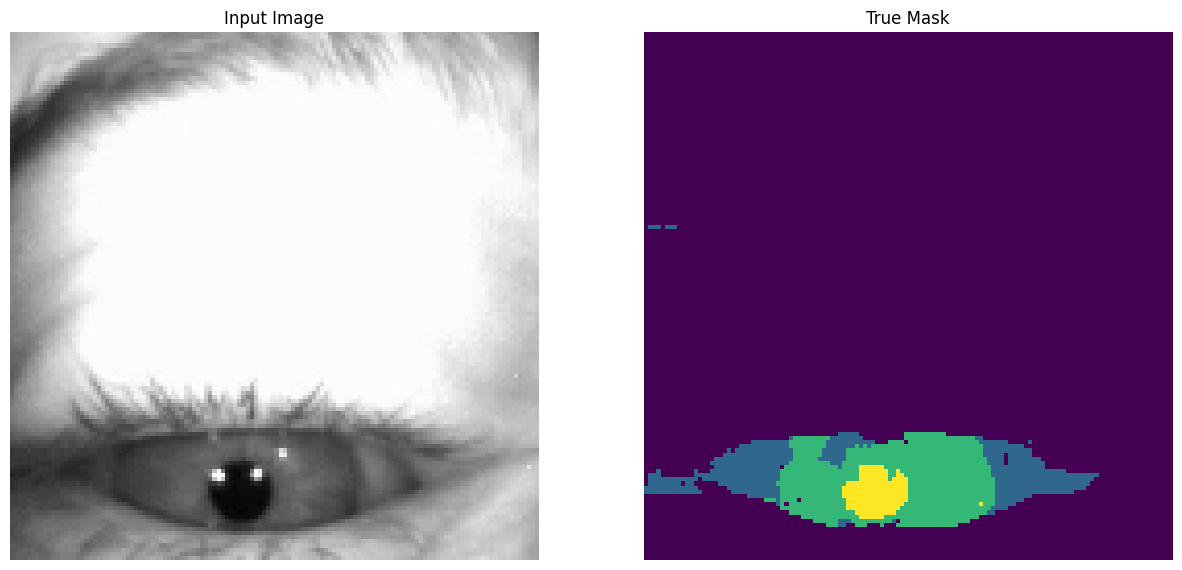

1/1 [==============================] - 0s 131ms/step


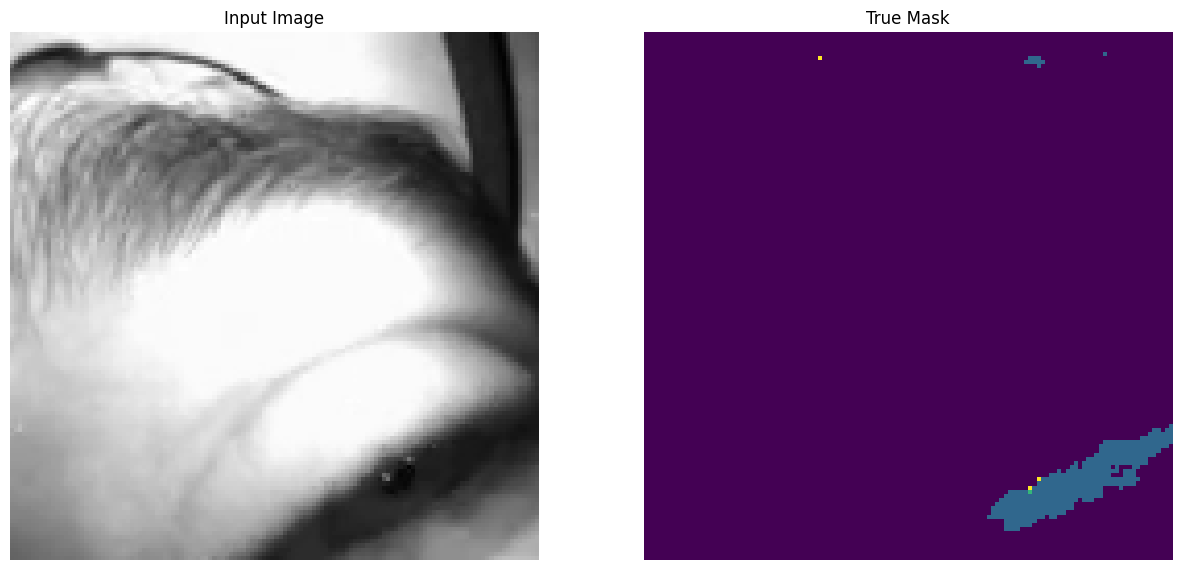

1/1 [==============================] - 0s 119ms/step


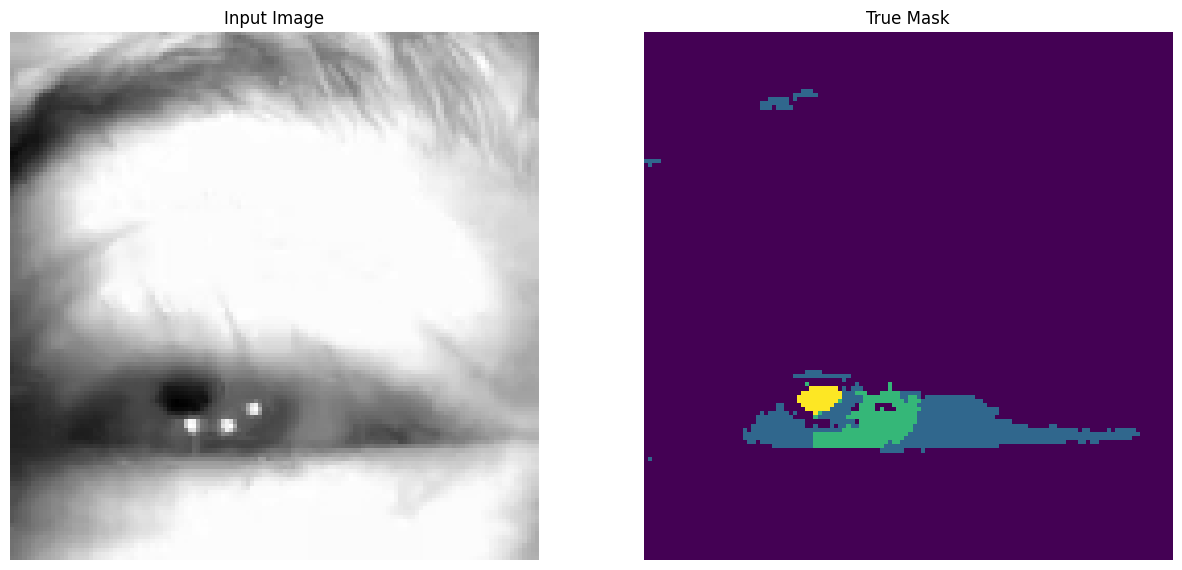

1/1 [==============================] - 0s 114ms/step


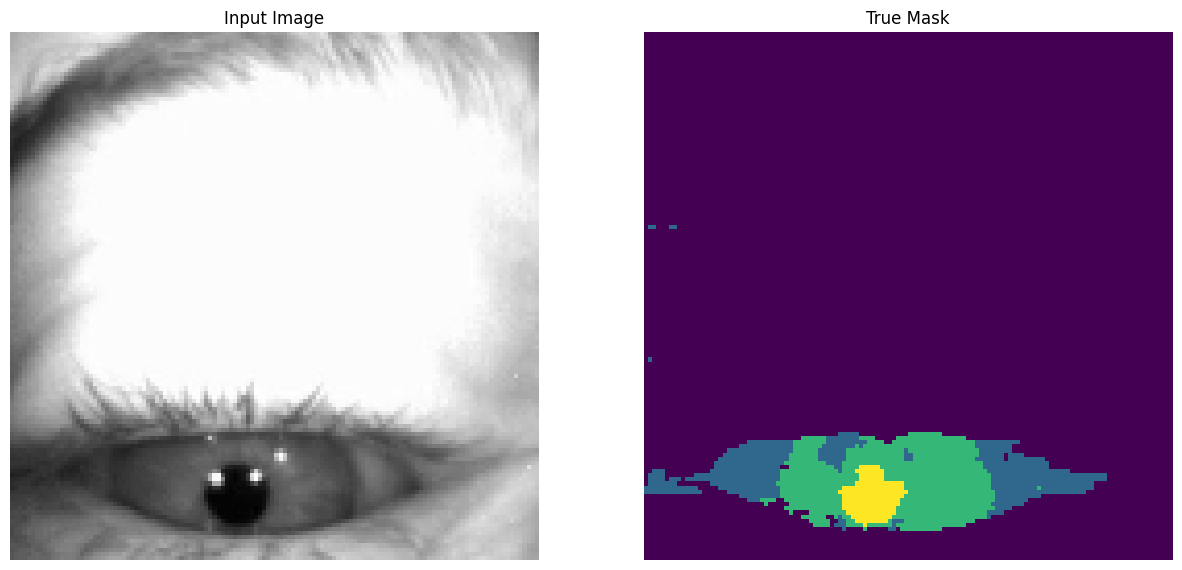

1/1 [==============================] - 0s 118ms/step


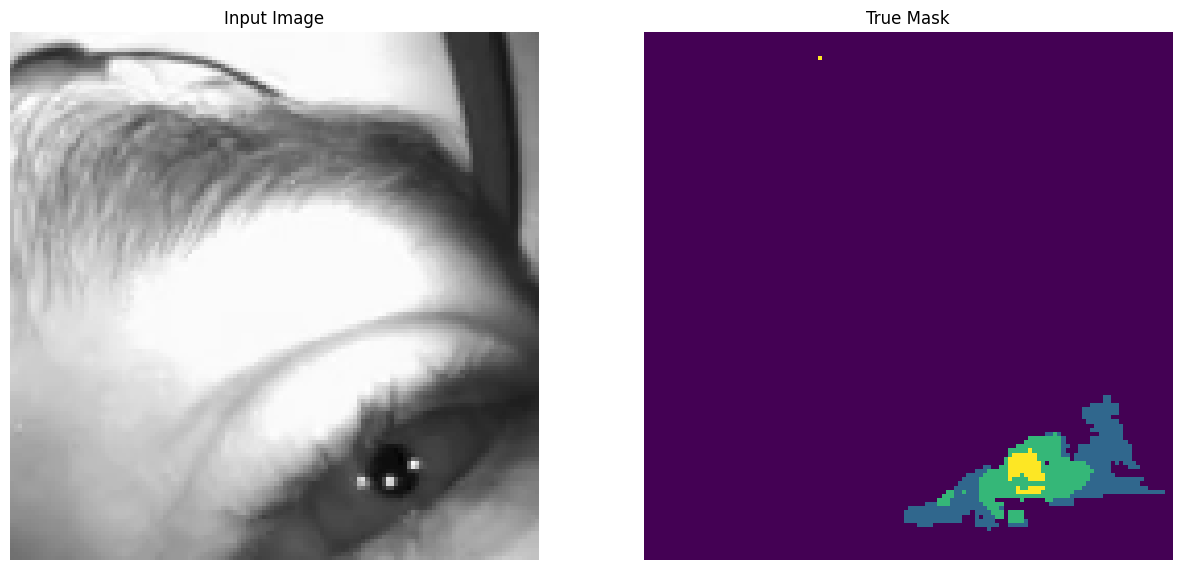

1/1 [==============================] - 0s 119ms/step


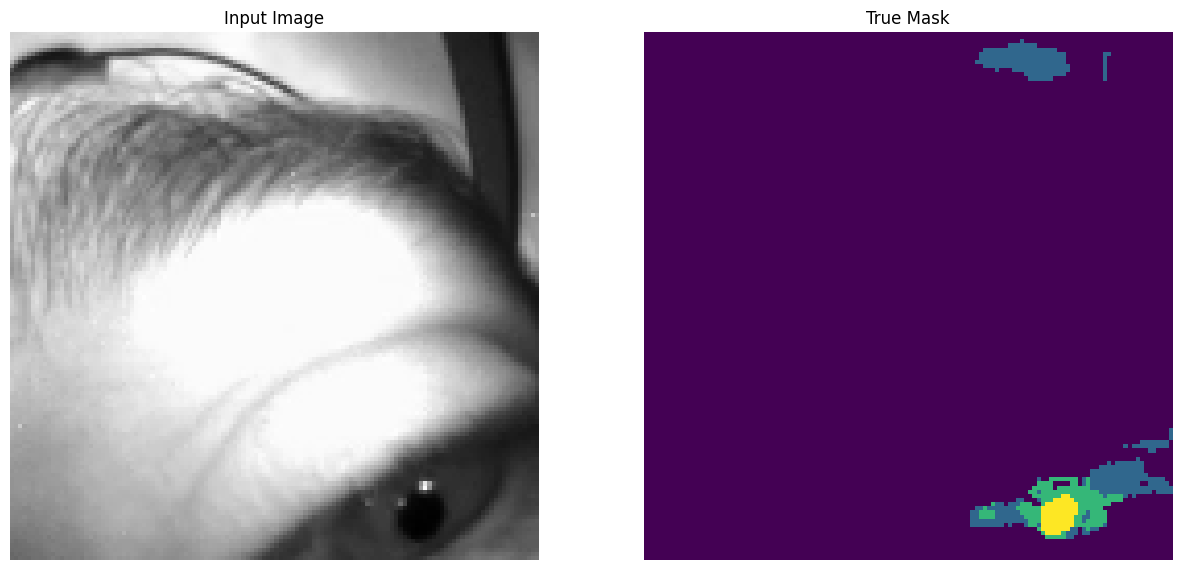

1/1 [==============================] - 0s 124ms/step


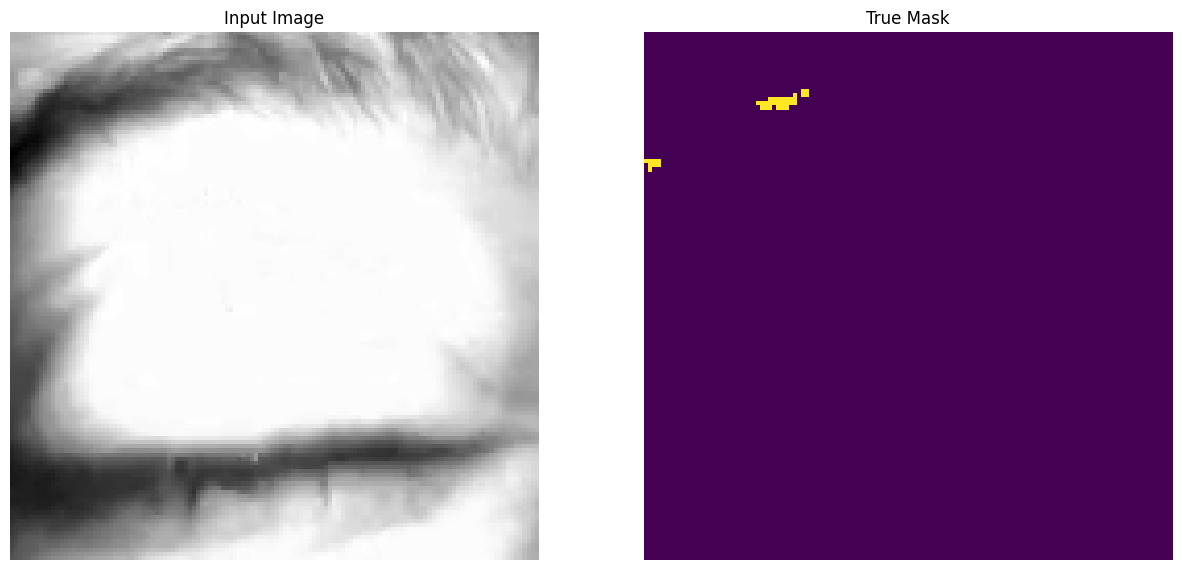

1/1 [==============================] - 0s 143ms/step


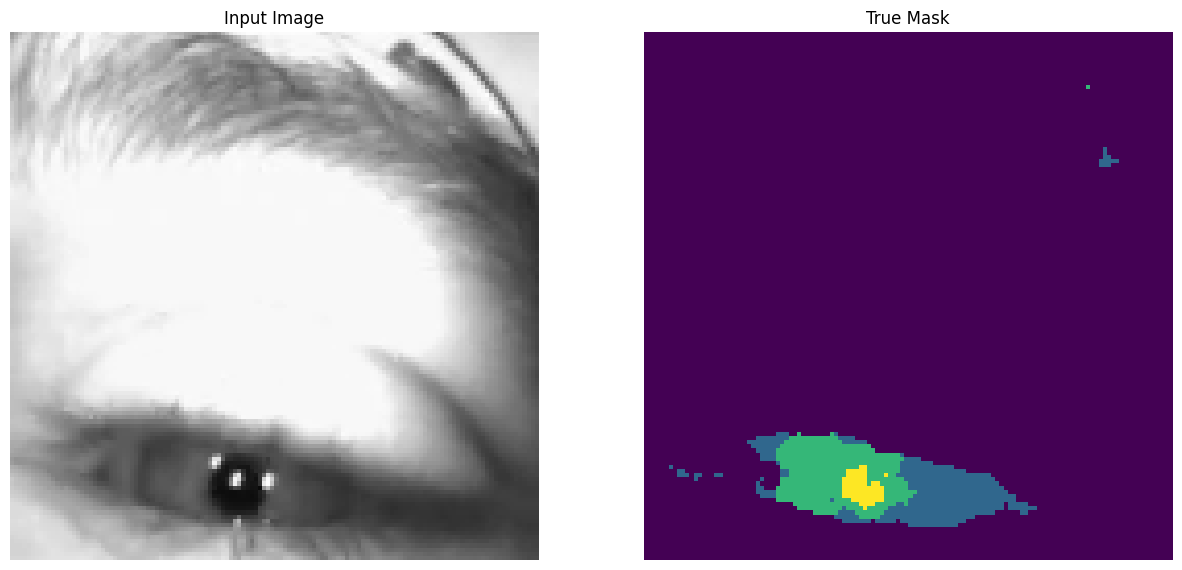

1/1 [==============================] - 0s 141ms/step


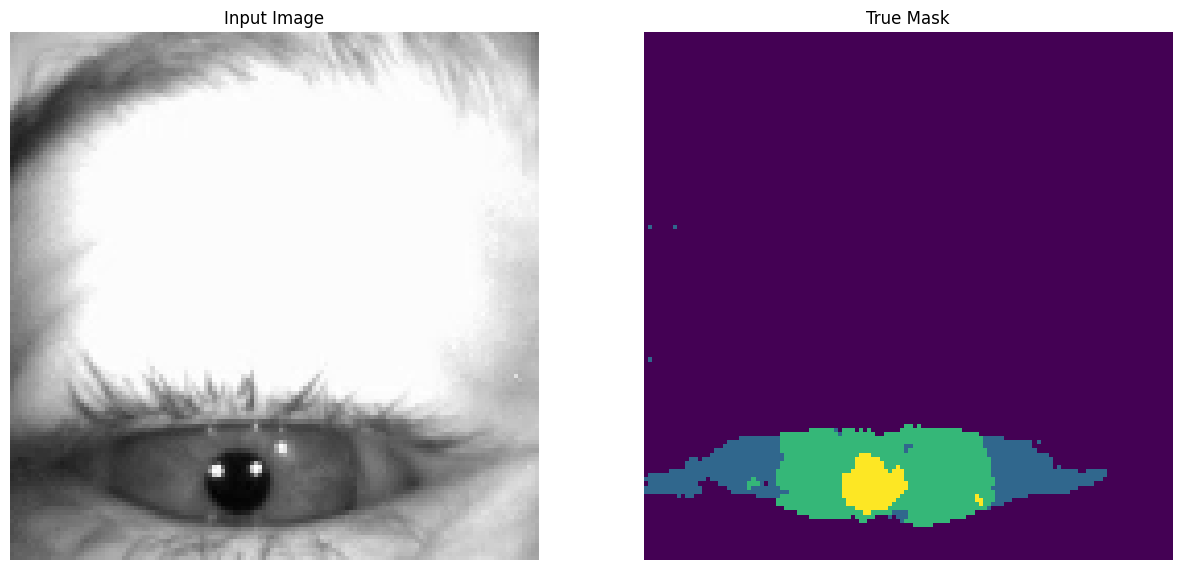

1/1 [==============================] - 0s 122ms/step


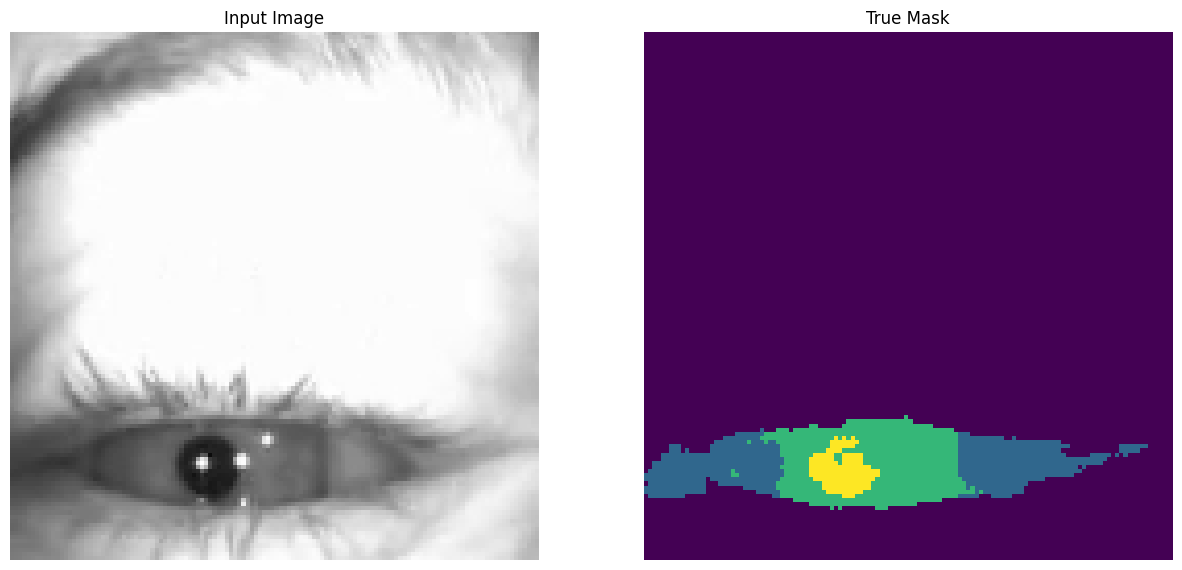

In [205]:
show_infer_predictions(dataset=infer_batch, num=10)